In [1]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# check if session is in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print('Google Colab session!')
except:
    IN_COLAB = False
    print('Not a Google Colab session.')

# add src path to the notebook
import os
import sys
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT: str = '/content/drive/MyDrive/papers/2025b_relevance_2.0'
    !pip install contextily esda deep-translator h3pandas h3~=3.0 datasets optuna setfit
else:
    PROJECT_ROOT: str = os.path.dirname(os.path.abspath(os.path.dirname("__file__")))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

Not a Google Colab session.
/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_Relevance_Classification


# Preparation and Evaluation of Non-Text Features
Before doing anything, we need to evaluate the predictive power of non-text features for relevance classification. Therefore, let's load the data we have and run a few experiments.

In [2]:
import warnings
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, root_mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm
from shapely import wkt
from src.model_training.classification_head import optimise_model
from src.emotions import get_class_probs
tqdm.pandas()
sns.set_style('ticks')

# surpress ConvergenceWarnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

# set data path
DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
RESULTS_PATH: str = os.path.join(PROJECT_ROOT, 'results')
LABEL_COLUMN: str = 'human_label_100km'
print(DATA_PATH)

/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_Relevance_Classification/data


## 1. Feature Engineering
Before going deeper into the data, we need some additional features as the spatial/temporal distance alone does not seem to suffice. A first natural choice are the emotion/sentiment probilities.

In [3]:
relevance_tweets: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_prepared.parquet')
)
print(relevance_tweets.shape)
print(relevance_tweets['use_case'].unique())
pd.DataFrame(relevance_tweets).head()  # ugly workaround due to a bug in VS Code

(4574, 28)
['Chile 🔥' 'Germany 🌊' 'Italy 🌊' 'California 🔥' 'Turkey 🪨']


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,human_label_50km,human_label_100km,event_distance_km,event_distance_h,event_distance_h_abs,n_disaster_tweets_1km,n_disaster_tweets_5km,n_disaster_tweets_10km,n_disaster_tweets_50km,n_disaster_tweets_10000km
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32775 -34.61872),None,@sanchezzdiegoo Quíhuboo,0,-7606507.783,...,Not related,Not related,187.471418,103.780833,103.780833,0.0,0.0,0.0,0.0,0.0
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86406 -32.88166),None,Cómo extraño ir a la aristides a ver los parti...,0,-7666204.585,...,Not related,Not related,130.387937,20.741111,20.741111,0.0,0.0,0.0,0.0,0.0
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39489 -35.96467),None,Es un robo de agua pohhhhhhh,1,-7947942.472,...,Not related,Not related,10.478844,49.941111,49.941111,4.0,4.0,5.0,16.0,736.0
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63593 -33.36501),None,@anakarinagcm Temazo ese,0,-7863444.522,...,Not related,Not related,10.698411,-152.212222,152.212222,0.0,0.0,0.0,0.0,0.0
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77574 -28.46427),None,La primer grieta del 2023 en Catamarca está en...,1,-7322394.226,...,Not related,Not related,396.327532,69.789444,69.789444,1.0,1.0,1.0,1.0,203.0


In [4]:
# extract emotion probabilities
emotion_probabilities: pd.DataFrame = get_class_probs(
    texts=relevance_tweets['text'], model='MilaNLProc/xlm-emo-t'
)

# extract sentiment probabilities
sentiment_probabilities: pd.DataFrame = get_class_probs(
    texts=relevance_tweets['text'], model='cardiffnlp/twitter-xlm-roberta-base-sentiment'
)

# concatenate the results
relevance_tweets['emotion_probs'] = emotion_probabilities.apply(lambda row: row.values, axis=1)
relevance_tweets['sentiment_probs'] = sentiment_probabilities.apply(lambda row: row.values, axis=1)
pd.DataFrame(relevance_tweets).head()  # ugly workaround due to a bug in VS Code

/home/david/miniconda3/envs/active-learning/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 4574/4574 [00:53<00:00, 86.26it/s] 


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,event_distance_km,event_distance_h,event_distance_h_abs,n_disaster_tweets_1km,n_disaster_tweets_5km,n_disaster_tweets_10km,n_disaster_tweets_50km,n_disaster_tweets_10000km,emotion_probs,sentiment_probs
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32775 -34.61872),None,@sanchezzdiegoo Quíhuboo,0,-7606507.783,...,187.471418,103.780833,103.780833,0.0,0.0,0.0,0.0,0.0,"[0.1116873100399971, 0.08837432414293289, 0.76...","[0.24736149609088898, 0.2910509407520294, 0.46..."
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86406 -32.88166),None,Cómo extraño ir a la aristides a ver los parti...,0,-7666204.585,...,130.387937,20.741111,20.741111,0.0,0.0,0.0,0.0,0.0,"[0.0013001792831346393, 0.0009399839327670634,...","[0.7456169724464417, 0.16595792770385742, 0.08..."
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39489 -35.96467),None,Es un robo de agua pohhhhhhh,1,-7947942.472,...,10.478844,49.941111,49.941111,4.0,4.0,5.0,16.0,736.0,"[0.011820702813565731, 0.006169864907860756, 0...","[0.01800038106739521, 0.11428425461053848, 0.8..."
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63593 -33.36501),None,@anakarinagcm Temazo ese,0,-7863444.522,...,10.698411,-152.212222,152.212222,0.0,0.0,0.0,0.0,0.0,"[0.7321125268936157, 0.24522025883197784, 0.00...","[0.4914751648902893, 0.4647566080093384, 0.043..."
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77574 -28.46427),None,La primer grieta del 2023 en Catamarca está en...,1,-7322394.226,...,396.327532,69.789444,69.789444,1.0,1.0,1.0,1.0,203.0,"[0.003971186000853777, 0.9815961718559265, 0.0...","[0.773543119430542, 0.2026240974664688, 0.0238..."


Next up, we can try to encode some spatial features. Namely, let's first encode the concrete event as a one-hot vector. 

In [5]:
event_encoding: pd.Series = pd.get_dummies(relevance_tweets['use_case'], dtype=int)
relevance_tweets['event_encoding'] = event_encoding.apply(lambda row: row.values, axis=1)
pd.DataFrame(relevance_tweets.sample(5))

,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,event_distance_h,event_distance_h_abs,n_disaster_tweets_1km,n_disaster_tweets_5km,n_disaster_tweets_10km,n_disaster_tweets_50km,n_disaster_tweets_10000km,emotion_probs,sentiment_probs,event_encoding
1632,1.415450e+18,2021-07-14 22:59:13,Germany 🌊,Die Lösungen kann nur sein:Größere Autos um du...,de,POINT (6.80939 51.23523),None,Die Lösungen kann nur sein:\r\nGrößere Autos u...,1,7.585653e+05,...,0.000000,0.000000,8.0,8.0,10.0,58.0,584.0,"[0.0034468306694179773, 0.042838770896196365, ...","[0.5865475535392761, 0.21562200784683228, 0.19...","[0, 0, 1, 0, 0]"
36,1.621210e+18,2023-02-02 18:04:32,Chile 🔥,Turista por un día 2023 | Visita al barrio Lap...,es,POINT (-67.51720 -45.87663),http://pbs.twimg.com/media/Fn-vzuSXwAIf5Nd.jpg,Turista por un día 2023 | Visita al barrio Lap...,0,-7.516311e+06,...,66.075556,66.075556,0.0,0.0,0.0,0.0,0.0,"[0.1441320776939392, 0.07456382364034653, 0.36...","[0.0903768539428711, 0.688399612903595, 0.2212...","[0, 1, 0, 0, 0]"
4440,1.623650e+18,2023-02-09 11:53:56,Turkey 🪨,Sur içinde yapılan evlerin kapılarını açmak iç...,tr,POINT (40.19679 37.93349),http://pbs.twimg.com/media/FoheWKDXoAAGDJ8.jpg,Sur içinde yapılan evlerin kapılarını açmak iç...,1,4.474747e+06,...,10.261704,10.261704,33.0,33.0,35.0,54.0,2915.0,"[0.003600622760131955, 0.9828909039497375, 0.0...","[0.573169469833374, 0.33589619398117065, 0.090...","[0, 0, 0, 0, 1]"
4484,1.623690e+18,2023-02-09 14:27:42,Turkey 🪨,Etimesgut belediyesi ekipleri ile depremzedele...,tr,POINT (32.67888 39.92614),http://pbs.twimg.com/media/FoiBijdWIAA6F8A.jpg...,Etimesgut belediyesi ekipleri ile depremzedele...,1,3.637947e+06,...,52.569592,52.569592,34.0,60.0,110.0,403.0,2986.0,"[0.41587191820144653, 0.3347457945346832, 0.23...","[0.23793993890285492, 0.5364129543304443, 0.22...","[0, 0, 0, 0, 1]"
3834,1.619030e+18,2023-01-27 17:48:45,Turkey 🪨,Samsun İçin Sahil kesimine kar beklenmemektedi...,tr,POINT (36.33964 41.30932),None,Samsun İçin Sahil kesimine kar beklenmemektedi...,1,4.045423e+06,...,-282.386397,282.386397,10.0,13.0,14.0,18.0,335.0,"[0.0006820280686952174, 0.0007729079225100577,...","[0.066312775015831, 0.34197139739990234, 0.591...","[0, 0, 0, 0, 1]"


In addition, we might as well encode the event type (i.e. flood, wildfire or earthquake).

In [6]:
event_type: pd.Series = relevance_tweets['use_case'].str[-1]
event_type_encoding: pd.Series = pd.get_dummies(event_type, dtype=int)
relevance_tweets['event_type_encoding'] = event_type_encoding.apply(lambda row: row.values, axis=1)
pd.DataFrame(relevance_tweets.sample(5))

,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,event_distance_h_abs,n_disaster_tweets_1km,n_disaster_tweets_5km,n_disaster_tweets_10km,n_disaster_tweets_50km,n_disaster_tweets_10000km,emotion_probs,sentiment_probs,event_encoding,event_type_encoding
2753,1.285860e+18,2020-07-22 08:57:29,California 🔥,Fire can have drone.,None,POINT (-117.98237 34.00237),None,Fire can have drone.,0,-1.313374e+07,...,159.041944,0.0,0.0,0.0,0.0,0.0,"[0.009920033626258373, 0.40560635924339294, 0....","[0.7869226932525635, 0.12622493505477905, 0.08...","[1, 0, 0, 0, 0]","[0, 1, 0]"
1609,1.415990e+18,2021-07-16 11:10:00,Germany 🌊,Bitte helft den #Hochwasser - Betroffenen. Es ...,de,POINT (9.73105 53.69482),None,Bitte helft den #Hochwasser - Betroffenen. Es ...,1,1.083792e+06,...,0.000000,1.0,1.0,1.0,29.0,1175.0,"[0.8184452652931213, 0.046632181853055954, 0.1...","[0.4859117269515991, 0.39290231466293335, 0.12...","[0, 0, 1, 0, 0]","[1, 0, 0]"
2915,1.267750e+18,2020-06-02 09:21:26,California 🔥,IM SCREAMING hats off to him because I was in ...,None,POINT (-118.41191 34.02069),None,IM SCREAMING hats off to him because I was in ...,0,-1.318155e+07,...,38.642778,0.0,0.0,0.0,0.0,0.0,"[0.003401052439585328, 0.0785440057516098, 0.0...","[0.9140175580978394, 0.06862881779670715, 0.01...","[1, 0, 0, 0, 0]","[0, 1, 0]"
3961,1.624760e+18,2023-02-12 13:07:58,Turkey 🪨,@user Yabancı arama kurtarmaya gelenler yakind...,tr,POINT (32.90415 39.96890),None,@odatv Yabancı arama kurtarmaya gelenler yakin...,0,3.663022e+06,...,123.240703,0.0,0.0,0.0,0.0,0.0,"[0.15986445546150208, 0.7876084446907043, 0.01...","[0.8979684114456177, 0.06664133816957474, 0.03...","[0, 0, 0, 0, 1]","[0, 0, 1]"
1367,1.417230e+18,2021-07-19 20:59:21,Germany 🌊,@user @user @user Nimes France. http,fr,POINT (7.26112 50.45479),http://pbs.twimg.com/media/E6sA8s-XEAQfB4b.jpg...,@JesseWatkins20 @DouniaBeneddine @MDegen55 Nim...,0,8.088380e+05,...,68.989167,0.0,0.0,0.0,0.0,0.0,"[0.6977246403694153, 0.03636676073074341, 0.20...","[0.8842241764068604, 0.09405633807182312, 0.02...","[0, 0, 1, 0, 0]","[1, 0, 0]"


Lastly, we can also encode the centroid for each use case.

In [7]:
relevance_tweets_dissolved: gpd.GeoDataFrame = relevance_tweets.dissolve(by='use_case')
relevance_tweets_dissolved['lon_centre'] = relevance_tweets_dissolved.geometry.centroid.x
relevance_tweets_dissolved['lat_centre'] = relevance_tweets_dissolved.geometry.centroid.y

if 'lon_centre' in relevance_tweets.columns:
    relevance_tweets = relevance_tweets.drop(columns=['lon_centre', 'lat_centre'])

relevance_tweets = relevance_tweets.merge(
    relevance_tweets_dissolved[['lon_centre', 'lat_centre']], left_on='use_case', right_index=True, how='left'
)
pd.DataFrame(relevance_tweets.sample(5))

/tmp/ipykernel_34677/222442392.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  relevance_tweets_dissolved['lon_centre'] = relevance_tweets_dissolved.geometry.centroid.x
/tmp/ipykernel_34677/222442392.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  relevance_tweets_dissolved['lat_centre'] = relevance_tweets_dissolved.geometry.centroid.y


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,n_disaster_tweets_5km,n_disaster_tweets_10km,n_disaster_tweets_50km,n_disaster_tweets_10000km,emotion_probs,sentiment_probs,event_encoding,event_type_encoding,lon_centre,lat_centre
2350,1.659620e+18,2023-05-19 17:57:57,Italy 🌊,A #Firenze di fronte al palazzo della Regione ...,it,POINT (11.24100 43.77688),https://t.co/8Fn28H0CON,A #Firenze di fronte al palazzo della Regione ...,1,1.251767e+06,...,199.0,236.0,351.0,1383.0,"[0.08860291540622711, 0.5766792893409729, 0.07...","[0.14503522217273712, 0.23623718321323395, 0.6...","[0, 0, 0, 1, 0]","[1, 0, 0]",11.266239,44.438038
3326,1.302710e+18,2020-09-06 20:51:28,California 🔥,🥵 no ac & no open windows to let in the wildfi...,None,POINT (-122.27952 37.87584),None,🥵 no ac & no open windows to let in the wildfi...,1,-1.361209e+07,...,6.0,6.0,52.0,292.0,"[0.10455288738012314, 0.6388593912124634, 0.13...","[0.5440081357955933, 0.39767715334892273, 0.05...","[1, 0, 0, 0, 0]","[0, 1, 0]",-119.708850,35.827047
3967,1.622620e+18,2023-02-06 15:18:20,Turkey 🪨,【M4.0】TURQUIA ORIENTAL 2km 06/02/2023 15:07:04...,ca,POINT (40.40946 39.19613),None,【M4.0】TURQUIA ORIENTAL 2km 06/02/2023 15:07:04...,1,4.498421e+06,...,1.0,1.0,1.0,1192.0,"[0.004640542436391115, 0.5506971478462219, 0.1...","[0.2941884696483612, 0.3168875277042389, 0.388...","[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595
3173,1.302810e+18,2020-09-07 03:43:32,California 🔥,People are evacuating and fire fighters are ri...,None,POINT (-122.43598 37.77064),None,People are evacuating and fire fighters are ri...,1,-1.362951e+07,...,16.0,17.0,58.0,343.0,"[0.05118145793676376, 0.01604415476322174, 0.7...","[0.30341407656669617, 0.3224470317363739, 0.37...","[1, 0, 0, 0, 0]","[0, 1, 0]",-119.708850,35.827047
3491,1.311980e+18,2020-10-02 11:00:44,California 🔥,The road is closed due to a brush fire. in #Az...,None,POINT (-117.89620 34.16370),None,The road is closed due to a brush fire. in #Az...,1,-1.312414e+07,...,6.0,7.0,79.0,429.0,"[0.05852339789271355, 0.7515628933906555, 0.16...","[0.10433733463287354, 0.7917287945747375, 0.10...","[1, 0, 0, 0, 0]","[0, 1, 0]",-119.708850,35.827047


We might also create a normalised version of these coordinates. For this, we can convert our latitude/longitude coordinates to 3D unit sphere coordinates.

In [8]:
relevance_tweets['sphere_x'] = np.cos(relevance_tweets['lat_centre']) * np.cos(relevance_tweets['lon_centre'])
relevance_tweets['sphere_y'] = np.cos(relevance_tweets['lat_centre']) * np.sin(relevance_tweets['lon_centre'])
relevance_tweets['sphere_z'] = np.sin(relevance_tweets['lat_centre'])
pd.DataFrame(relevance_tweets.sample(5))

,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,n_disaster_tweets_10000km,emotion_probs,sentiment_probs,event_encoding,event_type_encoding,lon_centre,lat_centre,sphere_x,sphere_y,sphere_z
18,1.632780e+18,2023-03-06 16:31:21,Chile 🔥,@user sanatın için teşekküker#AkınAkınözüpx,tr,POINT (-70.74012 -33.35411),None,@marisolyqr sanatın için teşekküker\r\n\r\n#...,0,-7.875043e+06,...,0.0,"[0.16623687744140625, 0.21896828711032867, 0.0...","[0.6134107112884521, 0.3532196879386902, 0.033...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159
1646,1.416390e+18,2021-07-17 13:27:21,Germany 🌊,@user @user @user Baerbock und die Grünen sind...,de,POINT (10.25095 53.72687),None,@Frei_Fink @Hagen_Westfalen @landnrw Baerbock ...,1,1.141661e+06,...,1597.0,"[0.00787281896919012, 0.009171469137072563, 0....","[0.10818967968225479, 0.7827572822570801, 0.10...","[0, 0, 1, 0, 0]","[1, 0, 0]",8.684652,50.557696,-0.707083,0.645793,0.288072
46,1.632910e+18,2023-03-07 01:11:09,Chile 🔥,Reconozco a la profesora @user una garantía pa...,es,POINT (-72.33297 -37.41911),None,Reconozco a la profesora @veronicaundurra una ...,0,-8.055391e+06,...,0.0,"[0.001081625116057694, 0.0010156437056139112, ...","[0.044373709708452225, 0.17171868681907654, 0....","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159
1155,1.416670e+18,2021-07-18 08:02:41,Germany 🌊,@user @user GOOD MORNING ISABELLA. ENJOY THE S...,en,POINT (7.26112 50.45479),http://pbs.twimg.com/media/E6kFntIWEAAsKlJ.jpg,@zazafontaine42 @MDegen55 GOOD MORNING ISABELL...,0,8.088380e+05,...,0.0,"[0.0005227064830251038, 0.0008117405814118683,...","[0.018058964982628822, 0.16141247749328613, 0....","[0, 0, 1, 0, 0]","[1, 0, 0]",8.684652,50.557696,-0.707083,0.645793,0.288072
3869,1.614590e+18,2023-01-15 12:00:26,Turkey 🪨,Hasret sana memleket!İyi ki doğdun #nazimhikme...,tr,POINT (30.49306 39.78285),http://pbs.twimg.com/media/FmgwF6oXkAIk8_w.jpg,Hasret sana memleket!\r\n\r\nİyi ki doğdun #na...,0,3.394647e+06,...,0.0,"[0.24329933524131775, 0.10844498872756958, 0.5...","[0.20482809841632843, 0.43790125846862793, 0.3...","[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312


Lastly, we compute ordinal integer labels for our classes.

In [ ]:
# train a label encoder and make our class integer labels
label_encoder: OrdinalEncoder = OrdinalEncoder(
    categories=[["Not related", "Related but not relevant", "Related and relevant"]]
)
relevance_tweets['int_label'] = label_encoder.fit_transform(relevance_tweets[[LABEL_COLUMN]]).astype(int)  # TODO: if needed, human label can be changed here

# save the label encoder
with open(os.path.join(DATA_PATH, 'processed', 'fine_tuning', f'train_label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

We can then save all these engineered features.

In [11]:
relevance_tweets.to_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_w_features.parquet')
)

## 2. Train/Test Split
Next, we need to prepare our training and evaluation data that we will use throughout the study.

Unfortunately, we fucked up the data selection during labelling a bit and it does not align with the regions defined for the Ahr Valley region in the paper. Before moving on with the paper, we need to fix this.

In [12]:
relevance_tweets: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_w_features.parquet')
)
print(relevance_tweets.shape)
print(relevance_tweets['use_case'].unique())
pd.DataFrame(relevance_tweets).head()  # ugly workaround due to a bug in VS Code

(4574, 38)
['Chile 🔥' 'Germany 🌊' 'Italy 🌊' 'California 🔥' 'Turkey 🪨']


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,emotion_probs,sentiment_probs,event_encoding,event_type_encoding,lon_centre,lat_centre,sphere_x,sphere_y,sphere_z,int_label
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32775 -34.61872),None,@sanchezzdiegoo Quíhuboo,0,-7606507.783,...,"[0.1116873100399971, 0.08837432414293289, 0.76...","[0.24736149609088898, 0.2910509407520294, 0.46...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86406 -32.88166),None,Cómo extraño ir a la aristides a ver los parti...,0,-7666204.585,...,"[0.0013001792831346393, 0.0009399839327670634,...","[0.7456169724464417, 0.16595792770385742, 0.08...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39489 -35.96467),None,Es un robo de agua pohhhhhhh,1,-7947942.472,...,"[0.011820702813565731, 0.006169864907860756, 0...","[0.01800038106739521, 0.11428425461053848, 0.8...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63593 -33.36501),None,@anakarinagcm Temazo ese,0,-7863444.522,...,"[0.7321125268936157, 0.24522025883197784, 0.00...","[0.4914751648902893, 0.4647566080093384, 0.043...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77574 -28.46427),None,La primer grieta del 2023 en Catamarca está en...,1,-7322394.226,...,"[0.003971186000853777, 0.9815961718559265, 0.0...","[0.773543119430542, 0.2026240974664688, 0.0238...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0


In [13]:
# Define the data for each event as a dictionary
filter_data: dict = {
    "event": [
        "California 🔥",
        "Germany 🌊",
        "Chile 🔥",
        "Italy 🌊",
        "Turkey 🪨"
    ],
    "raw_posts": [
        34678576,
        13023,
        1979072,
        43443,
        2723526
    ],
    "primary_languages": [
        "en, es",
        "de, en, nl, fr",
        "es, en",
        "it, en",
        "tr, en, ar"
    ],
    "temporal_extent": [
        "2020-04-01 to 2020-12-31",
        "2021-07-01 to 2021-07-31",
        "2023-01-01 to 2023-06-29",
        "2023-04-24 to 2023-05-30",
        "2023-01-01 to 2023-03-30"
    ],
    "geometry": [
        wkt.loads("POLYGON ((-112.85 31.83, -112.85 42.58, -124.43 42.58, -124.43 31.83, -112.85 31.83))"),
        wkt.loads("POLYGON ((6.00 50.01, 8.00 50.01, 8.00 50.75, 6.00 50.75, 6.00 50.01))"),
        wkt.loads("POLYGON ((-65.23 -54.81, -65.23 -17.32, -74.26 -17.32, -74.26 -54.81, -65.23 -54.81))"),
        wkt.loads("POLYGON ((13.00 43.66, 13.00 45.29, 9.75 45.29, 9.75 43.66, 13.00 43.66))"),
        wkt.loads("POLYGON ((43.95 33.80, 43.95 42.32, 29.18 42.32, 29.18 33.80, 43.95 33.80))")
    ]
}

# Create the GeoDataFrame, setting the coordinate reference system to WGS84 (EPSG:4326)
filter_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(filter_data, crs=4326)

# Split "Temporal Extent" into "start_date" and "end_date" and convert to datetime
filter_gdf[['start_date', 'end_date']] = filter_gdf['temporal_extent'].str.split(" to ", expand=True)
filter_gdf['start_date'] = pd.to_datetime(filter_gdf['start_date'])
filter_gdf['end_date'] = pd.to_datetime(filter_gdf['end_date'])

# Optionally, drop the original "Temporal Extent" column
filter_gdf = filter_gdf.drop(columns=["temporal_extent"])

# Make the event the index
filter_gdf = filter_gdf.set_index('event')

# save for later
filter_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'use_case_metadata.parquet'))

pd.DataFrame(filter_gdf).head()  # ugly workaround due to a bug in VS Code

,raw_posts,primary_languages,geometry,start_date,end_date
event,,,,,
California 🔥,34678576,"en, es","POLYGON ((-112.85000 31.83000, -112.85000 42.5...",2020-04-01,2020-12-31
Germany 🌊,13023,"de, en, nl, fr","POLYGON ((6.00000 50.01000, 8.00000 50.01000, ...",2021-07-01,2021-07-31
Chile 🔥,1979072,"es, en","POLYGON ((-65.23000 -54.81000, -65.23000 -17.3...",2023-01-01,2023-06-29
Italy 🌊,43443,"it, en","POLYGON ((13.00000 43.66000, 13.00000 45.29000...",2023-04-24,2023-05-30
Turkey 🪨,2723526,"tr, en, ar","POLYGON ((43.95000 33.80000, 43.95000 42.32000...",2023-01-01,2023-03-30


We can then go ahead and filter our data.

In [14]:
def row_is_valid(row: gpd.GeoSeries) -> bool:
    return (
        (row['date'] >= filter_gdf.loc[row['use_case'], 'start_date']) &
        (row['date'] <= filter_gdf.loc[row['use_case'], 'end_date']) &
        (row['geometry'].within(filter_gdf.loc[row['use_case'], 'geometry']))
    )
# relevance_tweets['valid'] = relevance_tweets.progress_apply(row_is_valid, axis=1)
relevance_tweets['valid'] = True  # ! for now, let's use all tweets
print(sum(relevance_tweets['valid']))
print(relevance_tweets[relevance_tweets['valid'] == True].groupby(['use_case']).size())
pd.DataFrame(relevance_tweets).head()  # ugly workaround due to a bug in VS Code

4574
use_case
California 🔥    1040
Chile 🔥          924
Germany 🌊       1026
Italy 🌊          542
Turkey 🪨        1042
dtype: int64


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,sentiment_probs,event_encoding,event_type_encoding,lon_centre,lat_centre,sphere_x,sphere_y,sphere_z,int_label,valid
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32775 -34.61872),None,@sanchezzdiegoo Quíhuboo,0,-7606507.783,...,"[0.24736149609088898, 0.2910509407520294, 0.46...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0,True
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86406 -32.88166),None,Cómo extraño ir a la aristides a ver los parti...,0,-7666204.585,...,"[0.7456169724464417, 0.16595792770385742, 0.08...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0,True
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39489 -35.96467),None,Es un robo de agua pohhhhhhh,1,-7947942.472,...,"[0.01800038106739521, 0.11428425461053848, 0.8...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0,True
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63593 -33.36501),None,@anakarinagcm Temazo ese,0,-7863444.522,...,"[0.4914751648902893, 0.4647566080093384, 0.043...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0,True
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77574 -28.46427),None,La primer grieta del 2023 en Catamarca está en...,1,-7322394.226,...,"[0.773543119430542, 0.2026240974664688, 0.0238...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0,True


Based on the data above, we can now create a train/test split.

In [ ]:
valid_tweets: gpd.GeoDataFrame = relevance_tweets[relevance_tweets['valid'] == True].copy()

# Use 20% of our data as a pool for  active learning, the rest is used for evaluation
train_gdf, test_gdf = train_test_split(valid_tweets, test_size=0.2, random_state=1,  # originally 0.3 random state 10 
                                       stratify=valid_tweets[LABEL_COLUMN])

print(f'Training data: {train_gdf.shape}')
print(train_gdf.groupby(['use_case']).size())
print(f'Test data: {test_gdf.shape}')

Training data: (3659, 39)
use_case
California 🔥    836
Chile 🔥         767
Germany 🌊       802
Italy 🌊         442
Turkey 🪨        812
dtype: int64
Test data: (915, 39)


While doing that, we also need to normalise our non-text features.

In [16]:
NON_TEXT_COLUMNS: list[str] = ['event_distance_km', 'event_distance_h', 'n_disaster_tweets_1km',
                               'n_disaster_tweets_10km', 'n_disaster_tweets_50km', 'n_disaster_tweets_10000km']

# define helper functions
def compute_mean_std_per_use_case(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Compute mean and std for each group in 'use_case' for a given column."""
    stats = df.groupby('use_case')[column].agg(['mean', 'std']).reset_index()
    return stats

def zscore_transform(value: float, mean: float, std: float) -> float:
    """Apply z-score transformation."""
    return (value - mean) / std

# For each column, compute the stats from training data and apply transformation
for col in NON_TEXT_COLUMNS:
    # Compute mean and std per use_case in training data
    train_mean_std_per_use_case: pd.DataFrame = compute_mean_std_per_use_case(train_gdf, col)

    # Merge the statistics back to the training data
    train_gdf = train_gdf.merge(train_mean_std_per_use_case, on='use_case', suffixes=('', f'_train'))
    train_gdf[f'{col}_norm'] = train_gdf.apply(lambda row: zscore_transform(row[col], row['mean'], row['std']), axis=1)
    train_gdf.drop(['mean', 'std'], axis=1, inplace=True)
    
    # # Merge the training statistics with the test data on use_case
    test_gdf = test_gdf.merge(train_mean_std_per_use_case, on='use_case', how='left')
    test_gdf[f'{col}_norm'] = test_gdf.apply(lambda row: zscore_transform(row[col], row['mean'], row['std']), axis=1)
    test_gdf.drop(['mean', 'std'], axis=1, inplace=True)
pd.DataFrame(train_gdf)

,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,sphere_y,sphere_z,int_label,valid,event_distance_km_norm,event_distance_h_norm,n_disaster_tweets_1km_norm,n_disaster_tweets_10km_norm,n_disaster_tweets_50km_norm,n_disaster_tweets_10000km_norm
0,1.296800e+18,2020-08-21 13:40:45,California 🔥,Closed due to the czu august lightning complex...,None,POINT (-122.36110 37.16663),None,Closed due to the czu august lightning complex...,1,-1.362118e+07,...,0.095685,-0.954961,1,True,-0.457531,-0.099120,-0.370997,-0.451317,0.758702,1.366236
1,1.417100e+18,2021-07-19 12:23:18,Germany 🌊,Mich beunruhigt nichts mehr.Wir sorgen persönl...,de,POINT (12.22671 51.84923),None,Mich beunruhigt nichts mehr.Wir sorgen persönl...,1,1.361556e+06,...,0.645793,0.288072,1,True,1.300809,0.095609,0.362793,0.052028,-0.467472,1.510834
2,1.341270e+18,2020-12-22 06:29:24,California 🔥,The view out my kitchen window of the massive ...,None,POINT (-118.41191 34.02069),None,The view out my kitchen window of the massive ...,1,-1.318155e+07,...,0.095685,-0.954961,2,True,-0.714648,0.772862,0.798591,0.527691,-0.172292,-0.719290
3,1.320860e+18,2020-10-26 22:49:26,California 🔥,@user @user @user I love 1/2 miles from Anahei...,None,POINT (-117.85109 33.84275),None,@ZestForLifeNow @City_of_Anaheim @AnaheimFire ...,1,-1.311912e+07,...,0.095685,-0.954961,2,True,-0.714648,-0.099120,-0.105182,-0.068227,0.592908,-0.276396
4,1.296050e+18,2020-08-19 11:26:50,California 🔥,Someone fucking set off my apartment building’...,None,POINT (-118.41191 34.02069),None,Someone fucking set off my apartment building’...,1,-1.318155e+07,...,0.095685,-0.954961,0,True,-0.714648,0.852190,2.446648,1.889790,1.001015,0.244985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,1.624650e+18,2023-02-12 06:18:19,Turkey 🪨,Hatay/Hassa'da en kazın altında çıkan not...#d...,tr,POINT (36.51252 36.78301),http://pbs.twimg.com/media/FovuSvIX0AUnSdz.jpg,Hatay/Hassa'da en kazın altında çıkan not...\r...,1,4.064655e+06,...,-0.317761,0.887312,2,True,-1.168961,-0.188440,-0.317823,-0.436595,0.543710,2.060679
3655,1.610290e+18,2023-01-03 15:19:57,Turkey 🪨,FutBol Sohbet programımızın yeni bölümü YouTub...,tr,POINT (33.78141 41.38023),http://pbs.twimg.com/media/FljqrPJWQAcU-DW.jpg,FutBol Sohbet programımızın yeni bölümü YouTub...,0,3.760672e+06,...,-0.317761,0.887312,0,True,0.882802,-2.645158,-0.544401,-0.635649,-0.646982,-1.109802
3656,1.627130e+18,2023-02-19 02:12:45,Chile 🔥,Pasando ahora 😭😭 #Coronel #Biobio #IncendioFor...,es,POINT (-73.22220 -37.00482),http://pbs.twimg.com/ext_tw_video_thumb/162712...,Pasando ahora 😭😭 #Coronel #Biobio #IncendioFor...,1,-8.154494e+06,...,0.869559,0.356159,2,True,-0.312896,0.300568,-0.480332,-0.410065,0.183655,0.021594
3657,1.416140e+18,2021-07-16 21:10:24,Germany 🌊,Rhein unterspült Uferstrasse in Basel und löst...,de,POINT (7.65276 47.57676),None,Rhein unterspült Uferstrasse in Basel und löst...,1,8.524011e+05,...,0.645793,0.288072,1,True,0.852110,-0.180118,-0.141470,-0.150951,-0.432042,0.471640


In [ ]:
# store the data for later
train_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'train_data.parquet'))
test_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'test_data.parquet'))
train_gdf.groupby(['use_case', LABEL_COLUMN])[['event_distance_km', 'event_distance_h']].agg(['mean', 'std'])

event_distance_km              \
                                                   mean         std   
use_case     human_label_100km                                        
California 🔥 Not related                       6.609167    9.395975   
             Related and relevant              6.739872    8.619537   
             Related but not relevant          5.455827    8.195113   
Chile 🔥      Not related                      56.296358   99.177733   
             Related and relevant              7.932048   12.160080   
             Related but not relevant         15.870709   32.315196   
Germany 🌊    Not related                      58.033606  125.415256   
             Related and relevant              9.373035   22.144878   
             Related but not relevant        185.567972  155.872489   
Italy 🌊      Not related                      28.611659   29.624610   
             Related and relevant              4.222932   12.251793   
             Related but not relevant         15.222892   21.806113   
Turkey 🪨     Not related                     267.617276  194.599238   
             Related and relevant             33.930809   34.702433   
             Related but not relevant        271.646936  192.913242   

                                      event_distance_h              
                                                  mean         std  
use_case     human_label_100km                                      
California 🔥 Not related                      0.496581   74.047707  
             Related and relevant             9.053257   53.572676  
             Related but not relevant         9.942617   55.458147  
Chile 🔥      Not related                      4.169532   96.926156  
             Related and relevant            -8.217192   90.667642  
             Related but not relevant        -6.388420   92.723339  
Germany 🌊    Not related                     62.164656  371.628602  
             Related and relevant            26.303401   62.797423  
             Related but not relevant        28.721890   48.789298  
Italy 🌊      Not related                     52.127222  112.396778  
             Related and relevant            36.711578   87.107578  
             Related but not relevant        81.836477  130.696041  
Turkey 🪨     Not related                     96.058903  552.475923  
             Related and relevant           116.736569  211.456313  
             Related but not relevant       184.562586  288.151653

In [ ]:
train_gdf.groupby([LABEL_COLUMN])[['event_distance_km_norm', 'event_distance_h_norm']].agg(['mean', 'std'])

event_distance_km_norm            \
                                           mean       std   
human_label_100km                                           
Not related                            0.112643  1.147890   
Related and relevant                  -0.407903  0.718205   
Related but not relevant               0.113387  0.931459   

                         event_distance_h_norm            
                                          mean       std  
human_label_100km                                         
Not related                          -0.013539  1.302549  
Related and relevant                 -0.048981  0.749628  
Related but not relevant              0.036642  0.792412

## 3. Prediction
With the training data in place, let's try to evaluate the predictive power of the features.

In [12]:
train_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'train_data.parquet'))
test_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'test_data.parquet'))

NON_TEXT_COLUMNS: list[str] = [
    'event_distance_km',
    'event_distance_h',
    'n_disaster_tweets_1km',
    'n_disaster_tweets_5km',  # this one is multicollinear!!
    'n_disaster_tweets_10km',
    'n_disaster_tweets_50km',
    'n_disaster_tweets_10000km'
]
NON_TEXT_COLUMNS_NORM: list[str] = [f'{x}_norm' for x in NON_TEXT_COLUMNS]

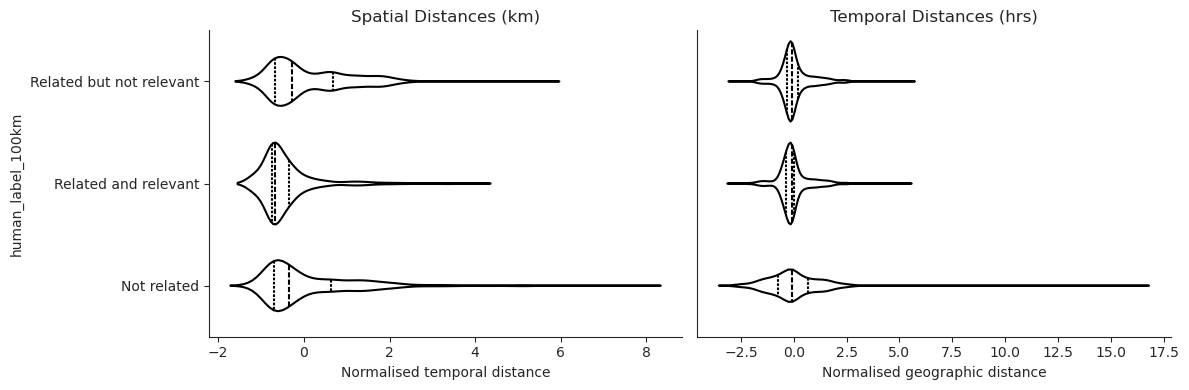

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.violinplot(data=train_gdf, y=LABEL_COLUMN, x='event_distance_km_norm', ax=axs[0], inner="quart", fill=False, color='k')
sns.violinplot(data=train_gdf, y=LABEL_COLUMN, x='event_distance_h_norm', ax=axs[1], inner="quart", fill=False, color='k')
axs[1].get_yaxis().set_visible(False)
axs[1].set_xlabel('Normalised geographic distance')
axs[0].set_xlabel('Normalised temporal distance')
axs[0].set_title('Spatial Distances (km)')
axs[1].set_title('Temporal Distances (hrs)')
fig.tight_layout()
sns.despine()

One danger that we have is that some of our non-text features are multicollinear. Therefore, let's compute the variance inflation factor (VIF) for our non-text features.

In [13]:
# X: np.ndarray = train_gdf[[f'{x}_norm' for x in NON_TEXT_COLUMNS]]
X: np.ndarray = train_gdf[NON_TEXT_COLUMNS]
vif_df: pd.DataFrame = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_df)

                     feature       VIF
0          event_distance_km  1.432349
1           event_distance_h  1.053460
2      n_disaster_tweets_1km  3.298105
3      n_disaster_tweets_5km  8.793929
4     n_disaster_tweets_10km  8.062056
5     n_disaster_tweets_50km  3.012971
6  n_disaster_tweets_10000km  2.496968


In [8]:
# Base features that are always utilised (assumed to be in your train_gdf)
base_features = {
    'regular': NON_TEXT_COLUMNS,
    'norm': [f'{x}_norm' for x in NON_TEXT_COLUMNS]
}

# Define the event and location encoding options
encoding_options = {
    "none": lambda df: np.empty((df.shape[0], 0)),  # returns an empty array so hstack works
    "event_type_encoding": lambda df: np.vstack(df['event_type_encoding'].values),
    "sphere_coords": lambda df: df[['sphere_x', 'sphere_y', 'sphere_z']].values,
    "event_type_encoding + sphere_coords": lambda df: np.hstack([
        np.vstack(df['event_type_encoding'].values),
        df[['sphere_x', 'sphere_y', 'sphere_z']].values
    ])
}

# Models to evaluate
models = {
    "logistic_regression": LogisticRegression(random_state=1),
    "random_forest": RandomForestClassifier(random_state=2),
    "svm": SVC(probability=True, random_state=3),
    # "xgboost": xgb.XGBClassifier(random_state=4),
    "gradient_boosting": GradientBoostingClassifier(random_state=5),
    "knn": KNeighborsClassifier(),
    "naive_bayes": GaussianNB()
}

# Evaluate each model using cross_val_score
results: list = []
best_models_dict: dict = {}
best_test_f1: float = 0
best_test_prediction: np.ndarray = None

# Pre-calculate total number of iterations for the progress bar:
total_iters = len(encoding_options) * len(models) * len(base_features)
with tqdm(total=total_iters, desc="Overall progress") as pbar:
    # Iterate over every combination of base features, event encoding and emotion features
    for base_feature_name, base_feature_set in base_features.items():
        for enc_name, event_func in encoding_options.items():
            feature_set_name = f"{base_feature_name} + {enc_name}"

            # Construct the feature matrix for the training data
            X_base_train: np.ndarray = train_gdf[base_feature_set].values  # base features
            X_event_train: np.ndarray = event_func(train_gdf)  # event encoding features
            X_combined_train = np.hstack([X_base_train, X_event_train])
            y_train = train_gdf['int_label'].values

            # Construct the feature matrix for the test data
            X_base_test: np.ndarray = test_gdf[base_feature_set].values  # base features
            X_event_test: np.ndarray = event_func(test_gdf)             # event encoding features
            X_combined_test = np.hstack([X_base_test, X_event_test])
            
            # Evaluate each model on the current feature combination
            for model_name, model in models.items():
                # Here, optimise_model is assumed to be a function that performs hyperparameter tuning
                best_model, best_params, best_score = optimise_model(model, X_combined_train, y_train)
                predictions_int: np.ndarray = best_model.predict(X_combined_test)
                test_gdf[f'pred_{model_name}_{feature_set_name.replace(' + ', '_')}'] = predictions_int

                # predictions = label_encoder.inverse_transform(predictions_int)
                prec, rec, f1, support = precision_recall_fscore_support(test_gdf['int_label'], predictions_int, average='macro')
                rmse: float = root_mean_squared_error(y_true=test_gdf['int_label'], y_pred=predictions_int)
                mae: float = mean_absolute_error(y_true=test_gdf['int_label'], y_pred=predictions_int)

                # Compute ROC-AUC on test data (requires probability estimates)
                # For multi-class, we use one-vs-rest (ovr) strategy.
                if hasattr(best_model, "predict_proba"):
                    y_proba = best_model.predict_proba(X_combined_test)
                    roc_auc = roc_auc_score(y_true=test_gdf['int_label'], y_score=y_proba, multi_class='ovr')
                else:
                    roc_auc = np.nan  # Or handle decision_function if available   

                # Store best data for further analyses
                if f1 > best_test_f1:
                    best_test_f1 = f1
                    best_test_prediction = predictions_int             

                results.append({
                    "base_features": base_feature_name,
                    "event_encoding": enc_name,
                    "model": model_name,
                    "best_params": best_params,
                    "val_macro_f1": best_score,
                    "test_macro_prec": prec,
                    "test_macro_rec": rec,
                    "test_macro_f1": f1,
                    'test_acc': accuracy_score(y_true=test_gdf['int_label'], y_pred=predictions_int),
                    "test_roc_auc": roc_auc,
                    "test_rmse": rmse,
                    "test_mae": mae
                })
                best_models_dict[(feature_set_name, model_name)] = best_model

                # Update the progress bar
                pbar.update(1)

results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(RESULTS_PATH, 'non_text_model', 'evaluation_metrics_non_text.csv'), index=False)

# store all optimised  models as pickle file for later use
with open(os.path.join(RESULTS_PATH, 'non_text_model', 'all_models.pkl'), 'wb') as f:
    pickle.dump(best_models_dict, f)
print("All optimised models have been saved to 'all_best_models.pkl'")

# store test results
test_gdf.to_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))
results_df

Overall progress:   0%|          | 0/48 [00:00<?, ?it/s]Overall progress: 100%|██████████| 48/48 [11:58<00:00, 14.96s/it]


All optimised models have been saved to 'all_best_models.pkl'


,base_features,event_encoding,model,best_params,val_macro_f1,test_macro_prec,test_macro_rec,test_macro_f1,test_acc,test_roc_auc,test_rmse,test_mae
0,regular,none,logistic_regression,"{'C': 10, 'max_iter': 1000, 'penalty': 'l2', '...",0.585663,0.648924,0.617993,0.611093,0.674317,0.857465,0.709036,0.384699
1,regular,none,random_forest,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.677376,0.712826,0.703078,0.706997,0.731148,0.878270,0.640184,0.315847
2,regular,none,svm,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.573389,0.649406,0.593029,0.574616,0.679781,0.854439,0.615821,0.339891
3,regular,none,gradient_boosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.675347,0.695692,0.691466,0.693344,0.719126,0.876649,0.657034,0.331148
4,regular,none,knn,"{'n_neighbors': 9, 'weights': 'distance'}",0.659864,0.679874,0.671237,0.674649,0.700546,0.855519,0.663654,0.346448
5,regular,none,naive_bayes,{'var_smoothing': 1e-09},0.550328,0.629824,0.626258,0.589971,0.612022,0.826874,0.800273,0.472131
6,regular,event_type_encoding,logistic_regression,"{'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', ...",0.612572,0.674478,0.630163,0.626489,0.687432,0.858802,0.692663,0.368306
7,regular,event_type_encoding,random_forest,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.695765,0.733786,0.721535,0.726393,0.748634,0.889245,0.613153,0.292896
8,regular,event_type_encoding,svm,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.567000,0.648860,0.592215,0.572605,0.679781,0.854490,0.615821,0.339891
9,regular,event_type_encoding,gradient_boosting,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.688659,0.714870,0.712013,0.713262,0.735519,0.886994,0.636761,0.311475


Just to be sure, we might also try to fit a model per use case.

In [ ]:
# Base features (always utilized)
base_features = {
    'regular': NON_TEXT_COLUMNS,
    'norm': [f'{x}_norm' for x in NON_TEXT_COLUMNS]
}

# Event and location encoding options
encoding_options = {
    "event_type_encoding + sphere_coords": lambda df: np.hstack([
        np.vstack(df['event_type_encoding'].values),
        df[['sphere_x', 'sphere_y', 'sphere_z']].values
    ])
}

# Models to evaluate
models = {
    "logistic_regression": LogisticRegression(random_state=1),
    "random_forest": RandomForestClassifier(random_state=2),
    "svm": SVC(probability=True, random_state=3),
    # "xgboost": xgb.XGBClassifier(random_state=4),
    "gradient_boosting": GradientBoostingClassifier(random_state=5),
    "knn": KNeighborsClassifier(),
    "naive_bayes": GaussianNB()
}

# Get unique use cases (assumes both train and test share the same use cases)
use_cases = train_gdf['use_case'].unique()

# Prepare to store results and models
results_use_case = []
# The key now includes the use case: (feature_set_name, model_name, use_case)
best_models_dict = {}
best_test_f1: float = 0
best_test_prediction: np.ndarray = None

# Calculate total iterations: for each combination of base feature, encoding option, model and use case.
total_iters = len(base_features) * len(encoding_options) * len(models) * len(use_cases)
with tqdm(total=total_iters, desc="Overall progress") as pbar:
    # Iterate over base feature sets and event encodings
    for base_feature_name, base_feature_set in base_features.items():
        for enc_name, event_func in encoding_options.items():
            feature_set_name = f"{base_feature_name} + {enc_name}"
            # Loop over models
            for model_name, model in models.items():
                # Initialize a Series to store the aggregated predictions over all test rows.
                global_predictions = pd.Series(np.nan, index=test_gdf.index)
                global_probs = pd.Series(np.nan, index=test_gdf.index, dtype=object)
                
                # Loop over each use case to fit a model on the corresponding data
                for use_case in use_cases:
                    # Subset the training and test data by use case
                    train_subset = train_gdf[train_gdf['use_case'] == use_case]
                    test_subset = test_gdf[test_gdf['use_case'] == use_case]
                    
                    # If one of the subsets is empty, skip this use case.
                    if train_subset.empty or test_subset.empty:
                        pbar.update(1)
                        continue
                    
                    # Construct the feature matrix for the training subset
                    X_base_train = train_subset[base_feature_set].values
                    X_event_train = event_func(train_subset)
                    X_combined_train = np.hstack([X_base_train, X_event_train])
                    y_train = train_subset['int_label'].values
                    
                    # Construct the feature matrix for the test subset
                    X_base_test = test_subset[base_feature_set].values
                    X_event_test = event_func(test_subset)
                    X_combined_test = np.hstack([X_base_test, X_event_test])
                    
                    # Optimize (tune) and fit the model for the current use case
                    best_model, best_params, best_score = optimise_model(model, X_combined_train, y_train)
                    predictions_int = best_model.predict(X_combined_test)
                    predictions_prob = best_model.predict_proba(X_combined_test)
                    
                    # Store the fitted model for this use case
                    best_models_dict[(feature_set_name, model_name, use_case)] = best_model
                    
                    # Place the predictions into the global prediction Series using the original test indices
                    global_predictions.loc[test_subset.index] = predictions_int
                    global_probs[test_subset.index] = [element for element in predictions_prob.tolist()]
                    
                    pbar.update(1)
                
                # After processing all use cases for the current combination,
                # compute global evaluation metrics on the aggregated test predictions.
                y_test_global = test_gdf['int_label'].values
                prec, rec, f1, _ = precision_recall_fscore_support(y_test_global, global_predictions.values, average='macro')
                rmse = root_mean_squared_error(y_true=y_test_global, y_pred=global_predictions.values)
                mae = mean_absolute_error(y_true=y_test_global, y_pred=global_predictions.values)
                
                # Compute ROC-AUC if available (here we check if the last best_model supports predict_proba)
                if hasattr(best_model, "predict_proba"):
                    roc_auc = roc_auc_score(y_true=y_test_global, y_score=np.vstack(global_probs.values), multi_class='ovr')
                else:
                    roc_auc = np.nan
                    
                # Update global best model prediction if the current f1 is the best so far
                if f1 > best_test_f1:
                    best_test_f1 = f1
                    best_test_prediction = global_predictions.values
                
                # Save the results for the current combination (global evaluation)
                results_use_case.append({
                    "base_features": base_feature_name,
                    "event_encoding": enc_name,
                    "model": model_name,
                    "best_params": best_params,
                    "val_macro_f1": best_score,
                    "test_macro_prec": prec,
                    "test_macro_rec": rec,
                    "test_macro_f1": f1,
                    "test_acc": accuracy_score(y_true=y_test_global, y_pred=global_predictions.values),
                    "test_roc_auc": roc_auc,
                    "test_rmse": rmse,
                    "test_mae": mae
                })

# Save the evaluation metrics as a CSV file
results_use_case_df = pd.DataFrame(results_use_case)
results_use_case_df.to_csv(os.path.join(RESULTS_PATH, 'non_text_model', 'evaluation_metrics_non_text_use_case.csv'), index=False)
results_use_case_df

Overall progress:   0%|          | 0/60 [00:00<?, ?it/s]Overall progress: 100%|██████████| 60/60 [04:12<00:00,  4.22s/it]


,base_features,event_encoding,model,best_params,val_macro_f1,test_macro_prec,test_macro_rec,test_macro_f1,test_acc,test_roc_auc,test_rmse,test_mae
0,regular,event_type_encoding + sphere_coords,logistic_regression,"{'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', ...",0.675253,0.654917,0.647351,0.648300,0.690710,0.857265,0.685526,0.362842
1,regular,event_type_encoding + sphere_coords,random_forest,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.717357,0.704517,0.700270,0.701638,0.720219,0.881849,0.648664,0.326776
2,regular,event_type_encoding + sphere_coords,svm,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.699077,0.693160,0.684304,0.687906,0.715847,0.863002,0.634181,0.323497
3,regular,event_type_encoding + sphere_coords,gradient_boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.717183,0.705035,0.702138,0.703382,0.723497,0.872345,0.651186,0.325683
4,regular,event_type_encoding + sphere_coords,knn,"{'n_neighbors': 9, 'weights': 'distance'}",0.671981,0.700072,0.691929,0.695300,0.718033,0.865829,0.624631,0.318033
5,regular,event_type_encoding + sphere_coords,naive_bayes,{'var_smoothing': 1e-09},0.627114,0.654536,0.656885,0.625568,0.642623,0.834652,0.757476,0.429508
6,norm,event_type_encoding + sphere_coords,logistic_regression,"{'C': 10, 'max_iter': 1000, 'penalty': 'l2', '...",0.674585,0.651163,0.642989,0.642462,0.685246,0.862484,0.696596,0.371585
7,norm,event_type_encoding + sphere_coords,random_forest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.714845,0.703496,0.698946,0.700463,0.720219,0.880530,0.648664,0.326776
8,norm,event_type_encoding + sphere_coords,svm,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.696072,0.688561,0.679279,0.682899,0.712568,0.869633,0.641889,0.328962
9,norm,event_type_encoding + sphere_coords,gradient_boosting,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.730222,0.716221,0.711821,0.713745,0.733333,0.886904,0.635902,0.312568
